<a href="https://colab.research.google.com/github/michp15/statistical_learning_class/blob/main/stat_learn_classif_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
# Install necessary packages.

install.packages('corrplot')
install.packages('naniar')
install.packages('glmnet')
install.packages('caret')
install.packages('Boruta')
install.packages('car')
install.packages('FactoMineR')
install.packages('factoextra')
install.packages('umap')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppTOML’, ‘here’, ‘png’, ‘reticulate’, ‘RSpectra’




In [63]:
# Import packages.

library(utils)
library(corrplot)
library(naniar)
library(tidyverse)
library(tidyr)
library(caret)
library(car)
library(Boruta)
library(glmnet)
library(dplyr)
library(FactoMineR)
library(factoextra)
library(umap)

In [3]:
# Download dataset.

download.file('https://raw.githubusercontent.com/michp15/statistical_learning_class/refs/heads/main/bank-additional-full.csv', 'bank.csv')

In [4]:
# Read dataset.

df = read.csv('bank.csv', sep=';')

In [5]:
# Inspect dataset for correct formatting.

head(df)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,⋯,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,⋯,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
2,57,services,married,high.school,unknown,no,no,telephone,may,mon,⋯,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
3,37,services,married,high.school,no,yes,no,telephone,may,mon,⋯,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
4,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,⋯,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
5,56,services,married,high.school,no,no,yes,telephone,may,mon,⋯,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
6,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,⋯,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no


In [6]:
# View types.

str(df)

'data.frame':	41188 obs. of  21 variables:
 $ age           : int  56 57 37 40 56 45 59 41 24 25 ...
 $ job           : chr  "housemaid" "services" "services" "admin." ...
 $ marital       : chr  "married" "married" "married" "married" ...
 $ education     : chr  "basic.4y" "high.school" "high.school" "basic.6y" ...
 $ default       : chr  "no" "unknown" "no" "no" ...
 $ housing       : chr  "no" "no" "yes" "no" ...
 $ loan          : chr  "no" "no" "no" "no" ...
 $ contact       : chr  "telephone" "telephone" "telephone" "telephone" ...
 $ month         : chr  "may" "may" "may" "may" ...
 $ day_of_week   : chr  "mon" "mon" "mon" "mon" ...
 $ duration      : int  261 149 226 151 307 198 139 217 380 50 ...
 $ campaign      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ pdays         : int  999 999 999 999 999 999 999 999 999 999 ...
 $ previous      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ poutcome      : chr  "nonexistent" "nonexistent" "nonexistent" "nonexistent" ...
 $ emp.var.rate  : num  1.1 1.1 1.1 1

In [7]:
# View distributions of categorical data.

for (col in colnames(df)){
  if (!is.numeric(df[, col])){
    print(col)
    print(table(df[, col]))
    cat('\n\n')
  }
}

[1] "job"

       admin.   blue-collar  entrepreneur     housemaid    management 
        10422          9254          1456          1060          2924 
      retired self-employed      services       student    technician 
         1720          1421          3969           875          6743 
   unemployed       unknown 
         1014           330 


[1] "marital"

divorced  married   single  unknown 
    4612    24928    11568       80 


[1] "education"

           basic.4y            basic.6y            basic.9y         high.school 
               4176                2292                6045                9515 
         illiterate professional.course   university.degree             unknown 
                 18                5243               12168                1731 


[1] "default"

     no unknown     yes 
  32588    8597       3 


[1] "housing"

     no unknown     yes 
  18622     990   21576 


[1] "loan"

     no unknown     yes 
  33950     990    6248 


[1] "contact"

In [8]:
# Remove the 'duration' column. Removing 'duration' prevents data leakage.

duration_vec <- c()
index <- 1
for (col in colnames(df)){
  if (col == 'duration'){
    duration_vec[index] <- TRUE
  } else {
    duration_vec[index] <- FALSE
  }
  index <- index + 1
}
df <- df[, !duration_vec]
rm(duration_vec)
rm(index)

In [9]:
# Function that checks for and removes duplicates.

check_remove_duplicates <- function(df) {
  duplicates <- duplicated(df)

  if (any(duplicates)){
    cat('There are:', sum(duplicates), 'duplicates.')
    df <- df[!duplicates,]
    cat('\n\nDuplicates removed.')
  }

  return (df)
}

In [10]:
# Remove duplicates.

df <- check_remove_duplicates(df)

There are: 1784 duplicates.

Duplicates removed.

In [11]:
# Check for null values.

cat(any(is.na(df)))

FALSE

In [12]:
# Check dependent variable distribution.

table(df$y)


   no   yes 
34806  4598 

In [13]:
# The number of rows that have 'pdays' equal to 999.

sum(df$pdays == 999)

[1] 37890

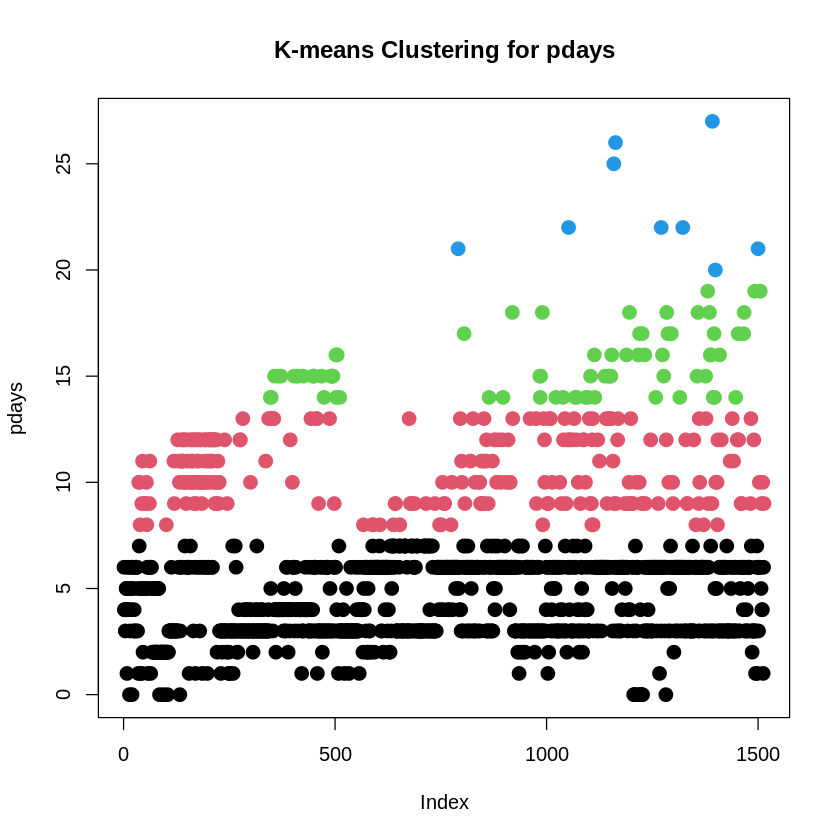

In [14]:
# Cluster 'pdays' in meaningful categories to resolve the '999' problem

set.seed(123)
kmeans_result <- kmeans(df[df$pdays != 999, 'pdays'], centers = 4, algorithm='Hartigan-Wong')
plot(df[df$pdays != 999, 'pdays'],
     col = kmeans_result$cluster,
     pch = 19,
     main = "K-means Clustering for pdays",
     xlab = "Index",
     ylab = "pdays",
     col.axis = "black",
     cex = 1.5)

In [15]:
# Check cluster separation.

kmeans_result$betweenss / kmeans_result$totss # -> well separated clusters

[1] 0.814126

In [16]:
# The cluster centroids.

kmeans_result$centers

1,4.29932
2,10.59375
3,15.54795
4,22.88889


In [17]:
# Function to get the index of the minimum value in a vector.

argmin <- function(vec){
  min <- vec[1]
  min_index <- 1
  for (i in 1:length(vec)){
    if (vec[i] < min){
      min <- vec[i]
      min_index <- i
    }
  }
  return (min_index)
}

# Function to compute the Euclidean distance between two 1D points.

euc_distance <- function(x, y){
  return (abs(y - x))  # sqrt((y - x)^2) simplifies to abs(y - x)
}

# Function to find the index of the closest value in a 1D vector.

argmin_distances <- function(x, vec){
  distances <- sapply(vec, function(v) euc_distance(x, v))
  return (argmin(distances))
}

# Encoding 'pdays' based on proximity to k-means cluster centers.

pdays_new_values <- character(nrow(df))

for (i in 1:nrow(df)){
  if (df[i, 'pdays'] == 999){
    pdays_new_values[i] <- 'Never'
  } else {
    temp <- argmin_distances(df[i, 'pdays'], kmeans_result$centers)
    temp <- switch(temp,
                   '1' = 'Very Recent',
                   '2' = 'Recent',
                   '3' = 'Moderate',
                   '4' = 'Older')
    pdays_new_values[i] <- temp
  }
}

df$pdays <- pdays_new_values

rm(pdays_new_values)

In [18]:
# Remove duplicates.

df <- check_remove_duplicates(df)

There are: 5 duplicates.

Duplicates removed.

In [25]:
# Find unique values for each categorical column.

for (colname in colnames(df)){
  if (!is.numeric(df[[colname]])){
    cat(colname,'\n')
    cat(unique(df[[colname]]))
    cat('\n\n')
  }
}

job 
housemaid services admin. blue-collar technician retired management unemployed self-employed unknown entrepreneur student

marital 
married single divorced unknown

education 
basic.4y high.school basic.6y basic.9y professional.course unknown university.degree illiterate

default 
no unknown yes

housing 
no yes unknown

loan 
no yes unknown

pdays 
Never Very Recent Recent Moderate Older

poutcome 
nonexistent failure success



In [20]:
# Encode dependent variable 'y'.

df$y <- as.numeric(ifelse(df$y == 'yes', 1, 0))

In [22]:
# Encode 'month' and 'day_of_week' columns.

for (i in 1:nrow(df)){
  df[i, 'month'] <- switch(df[i, 'month'],
                           'mar' = 0,
                           'apr' = 1,
                           'may' = 2,
                           'jun' = 3,
                           'jul' = 4,
                           'aug' = 5,
                           'sep' = 6,
                           'oct' = 7,
                           'nov' = 8,
                           'dec' = 9)

  df[i, 'day_of_week'] <- switch(df[i, 'day_of_week'],
                                 'mon' = 0,
                                 'tue' = 1,
                                 'wed' = 2,
                                 'thu' = 3,
                                 'fri' = 4)
}

df$month <- as.numeric(df$month)
df$day_of_week <- as.numeric(df$day_of_week)

df$sin_month <- sin(2 * pi * df$month / 10)
df$cos_month <- cos(2 * pi * df$month / 10)
df$sin_day_of_week <- sin(2 * pi * df$day_of_week / 5)
df$cos_day_of_week <- cos(2 * pi * df$day_of_week / 5)

df <- subset(df, select = -c(month, day_of_week))

In [24]:
# Encode the 'contact' column.

names(df)[names(df) == 'contact'] <- 'mobile_phone'
df$mobile_phone <- as.numeric(ifelse(df$mobile_phone == 'cellular', 1, 0))

In [26]:
# Remove duplicates.

df <- check_remove_duplicates(df)

In [27]:
df$loan_missing <- ifelse(df$loan == 'unknown', 1, 0)
df$housing_missing <- ifelse(df$housing == 'unknown', 1, 0)
df$default_missing <- ifelse(df$default == 'unknown', 1, 0)
df$education_missing <- ifelse(df$education == 'unknown', 1, 0)
df$marital_missing <- ifelse(df$marital == 'unknown', 1, 0)
df$job_missing <- ifelse(df$job == 'unknown', 1, 0)

In [28]:
# Convert all character columns to factors.

df[] <- lapply(df, function(x) if(is.character(x)) as.factor(x) else x)

In [29]:
str(df)

'data.frame':	39399 obs. of  28 variables:
 $ age              : int  56 57 37 40 56 45 59 41 24 25 ...
 $ job              : Factor w/ 12 levels "admin.","blue-collar",..: 4 8 8 1 8 8 1 2 10 8 ...
 $ marital          : Factor w/ 4 levels "divorced","married",..: 2 2 2 2 2 2 2 2 3 3 ...
 $ education        : Factor w/ 8 levels "basic.4y","basic.6y",..: 1 4 4 2 4 3 6 8 6 4 ...
 $ default          : Factor w/ 3 levels "no","unknown",..: 1 2 1 1 1 2 1 2 1 1 ...
 $ housing          : Factor w/ 3 levels "no","unknown",..: 1 1 3 1 1 1 1 1 3 3 ...
 $ loan             : Factor w/ 3 levels "no","unknown",..: 1 1 1 1 3 1 1 1 1 1 ...
 $ mobile_phone     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ campaign         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ pdays            : Factor w/ 5 levels "Moderate","Never",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ previous         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ poutcome         : Factor w/ 3 levels "failure","nonexistent",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ emp.var.rate     : num  1.1 1.1 

In [30]:
levels(df$education)

[1] "basic.4y"            "basic.6y"            "basic.9y"           
[4] "high.school"         "illiterate"          "professional.course"
[7] "university.degree"   "unknown"

In [38]:
any(is.na(df$education))

[1] FALSE

In [39]:
# Remove duplicates.

df <- check_remove_duplicates(df)

In [40]:
table(df$y)


    0     1 
34805  4594 

In [34]:
#write.csv(df, "df_with_missing_values_bank.csv", row.names = FALSE)

In [41]:
numerical.cols <- df[, sapply(df, is.numeric)]

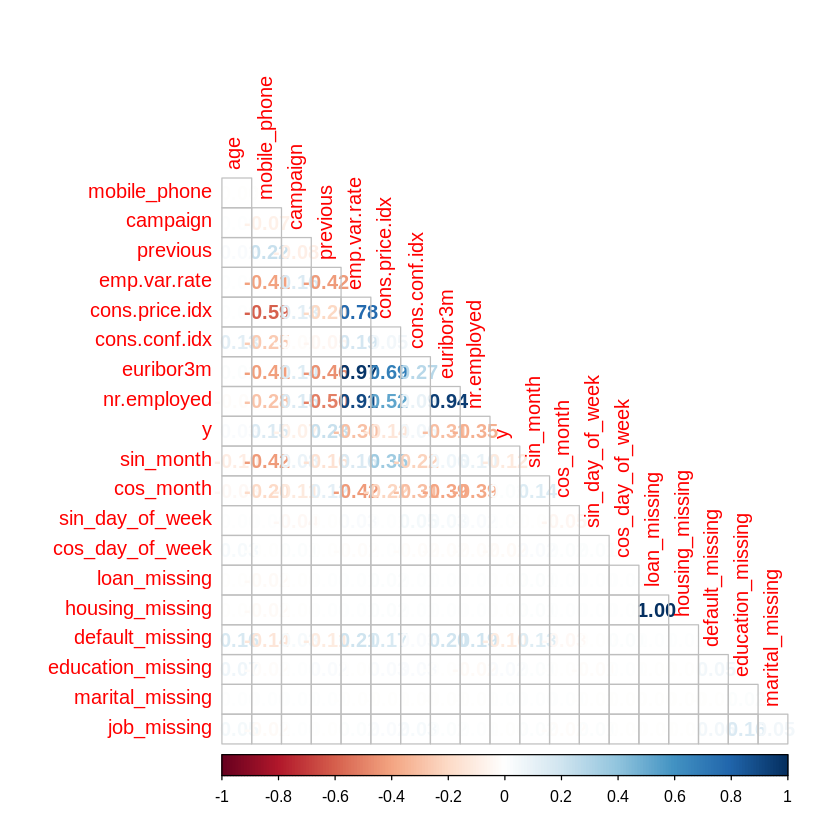

In [42]:
corrplot(cor(numerical.cols), method='number', type='lower', diag=FALSE)

In [46]:
factors <- c('job', 'marital', 'education', 'default',
             'housing', 'loan', 'pdays', 'poutcome')

In [47]:
# This creates dummies for all factors

dummies <- model.matrix(~ . - 1, data = df[factors])

In [50]:
# Drop the factor columns from df
df_numeric <- df[ , !(names(df) %in% factors)]

# Combine numeric + dummies
df_pca_ready <- cbind(df_numeric, dummies)

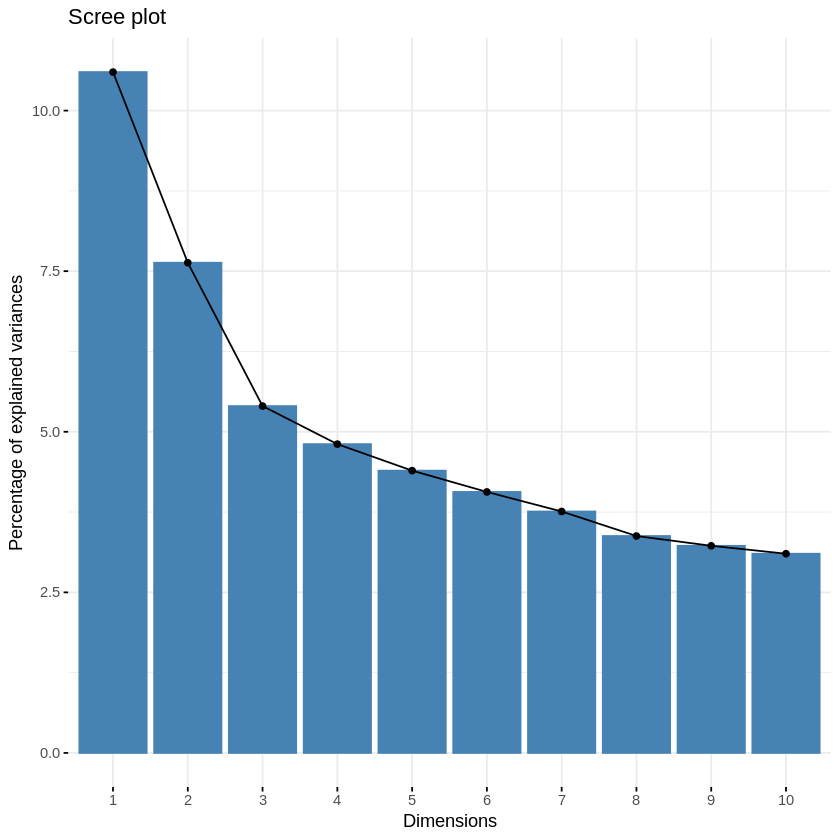

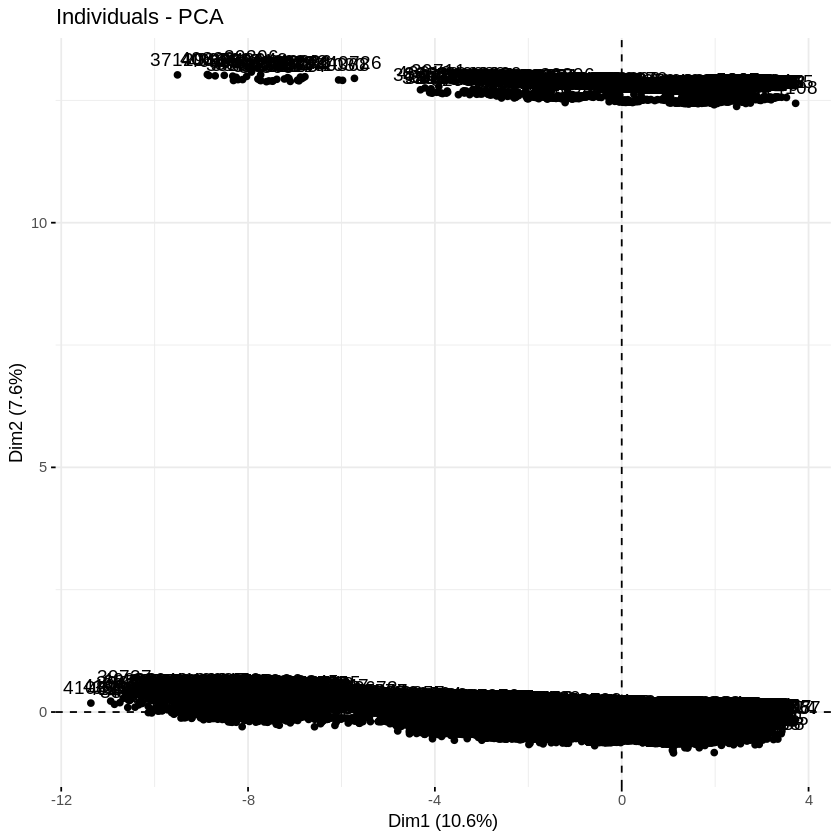

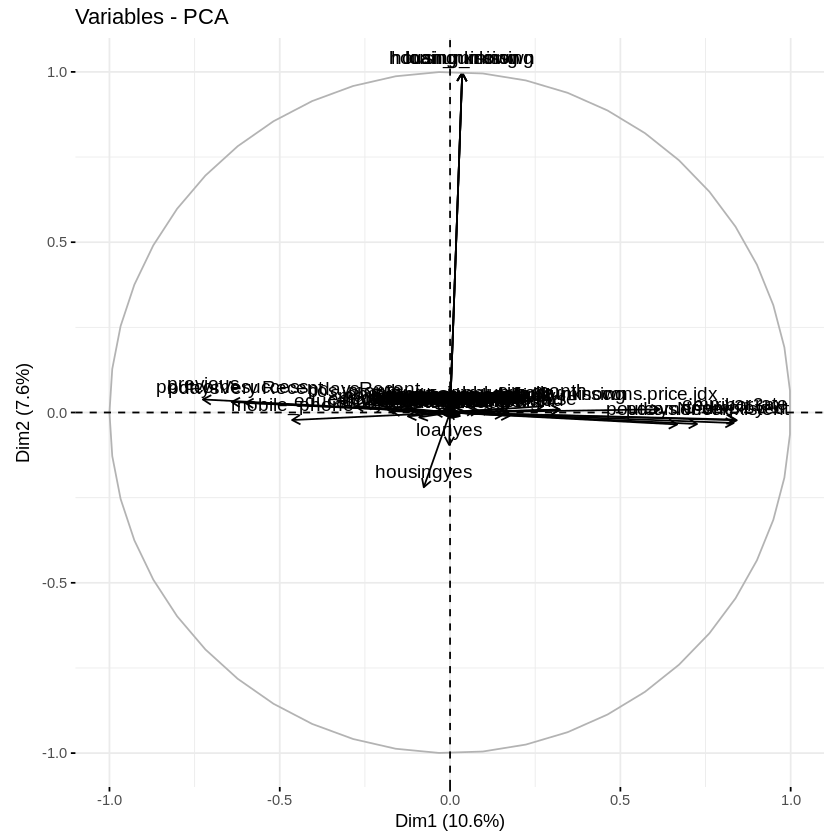

In [51]:
# PCA
res.pca <- PCA(subset(df_pca_ready, select=-y), graph=FALSE)

# Visualize
fviz_eig(res.pca)  # Scree plot
fviz_pca_ind(res.pca)  # Individuals
fviz_pca_var(res.pca)  # Variables

In [58]:
res.pca <- PCA(df_pca_ready, ncp = 2, scale.unit = TRUE, graph = FALSE)

In [59]:
pca_coords <- as.data.frame(res.pca$ind$coord)

In [60]:
pca_coords$y <- df$y

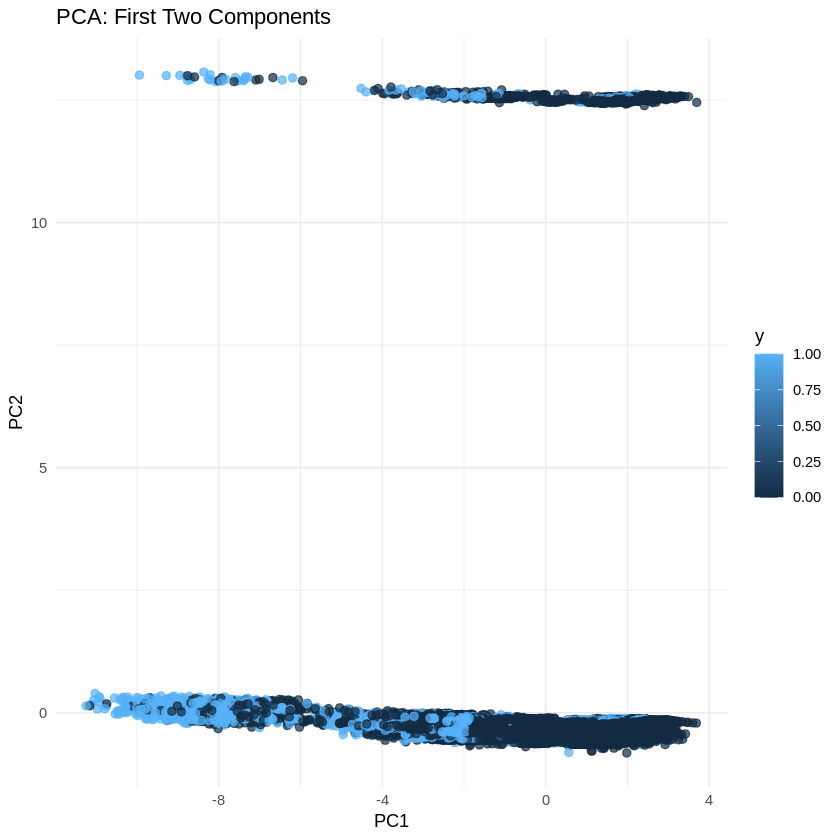

In [61]:
library(ggplot2)

ggplot(pca_coords, aes(x = Dim.1, y = Dim.2, color = y)) +
  geom_point(alpha = 0.7, size = 2) +
  labs(title = 'PCA: First Two Components', x = 'PC1', y = 'PC2') +
  theme_minimal()

In [64]:
# Assuming df_pca_ready is your data (already preprocessed)
df_scaled <- scale(df_pca_ready)  # Standardize data (mean = 0, sd = 1)

In [65]:
umap_result <- umap(df_scaled)

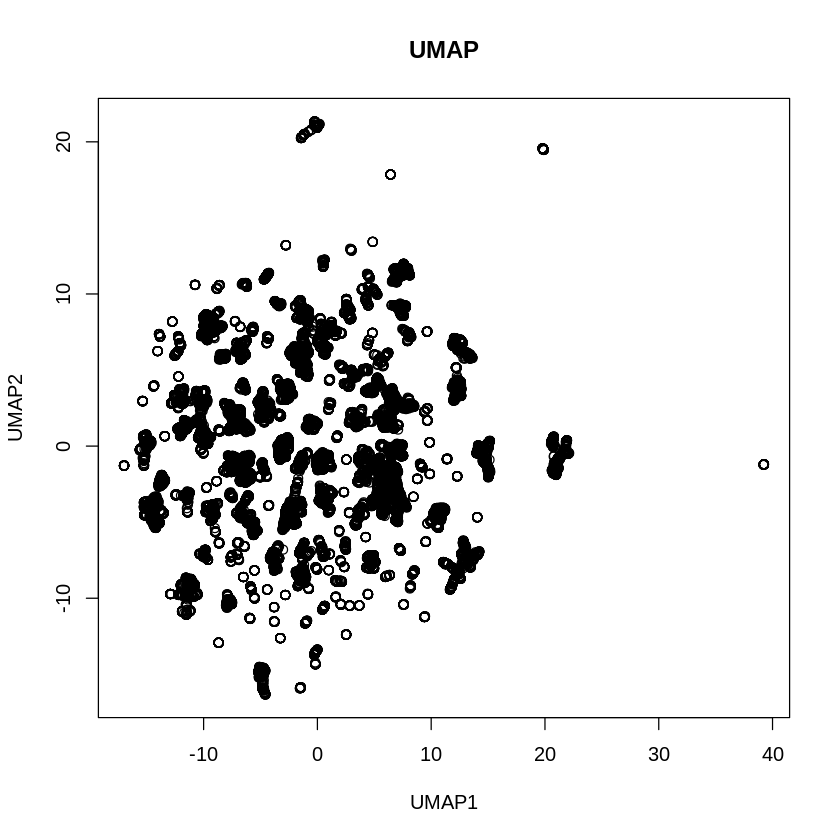

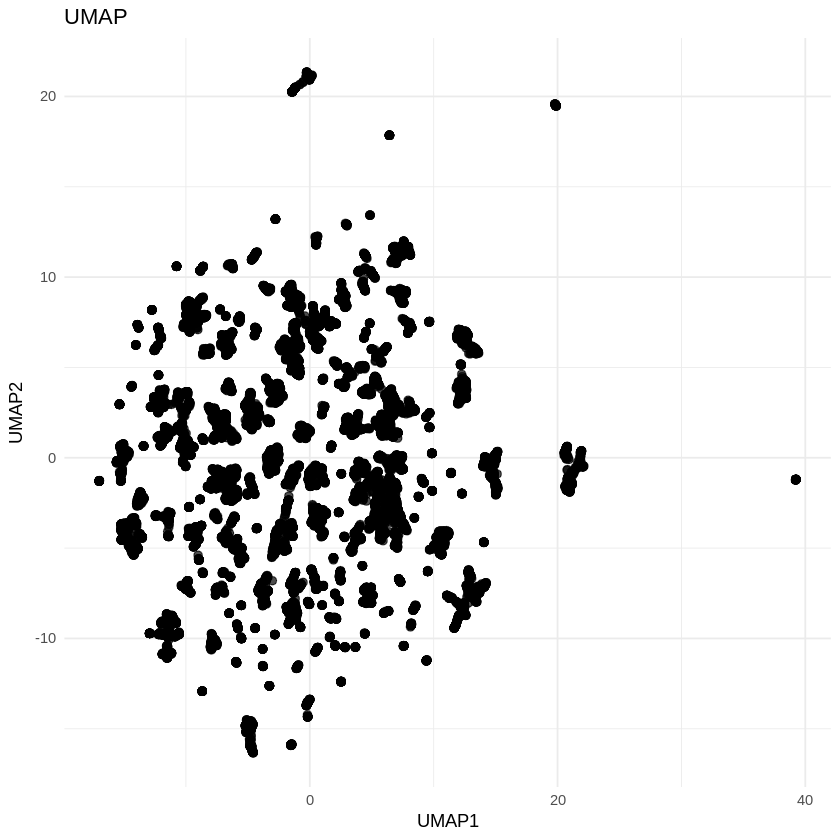

In [66]:
# Extract UMAP coordinates (2D by default)
umap_coords <- umap_result$layout

# Plot using base R
plot(umap_coords, main = 'UMAP', xlab = 'UMAP1', ylab = 'UMAP2')

# Or use ggplot for a more customizable plot
library(ggplot2)

umap_df <- as.data.frame(umap_coords)
colnames(umap_df) <- c('UMAP1', 'UMAP2')

ggplot(umap_df, aes(x = UMAP1, y = UMAP2)) +
  geom_point(alpha = 0.7, size = 2) +
  labs(title = 'UMAP', x = 'UMAP1', y = 'UMAP2') +
  theme_minimal()